----

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

Procedere a hacer un pequeño analisis de los csv para observar que no haya errores, datos faltantes, duplicados que no van, o datos sesgados con las graficas.

,id,f0,f1,f2,product
23537,FBZdR,1.728314,-0.109879,-1.057583,118.720992
75097,Xw8G0,0.877645,0.196001,5.999013,135.533579
41767,tIm2z,1.810808,-0.065190,4.216440,158.407149
94071,Y92D6,0.123998,-0.058400,5.852940,148.378883
58377,UmIFB,1.995698,0.097939,2.771874,24.651454
9644,l1khh,0.466275,1.119203,6.016950,105.109341
39602,IeYxI,-0.298770,0.974641,2.923927,82.975308
14187,Wmtq3,1.915324,0.086148,4.167503,150.173108
43527,TgUub,0.883483,0.454556,5.351403,76.714338
54010,VQtJ3,-0.151937,0.392837,0.784466,183.434949


<bound method DataFrame.info of           id        f0        f1        f2     product
0      txEyH  0.705745 -0.497823  1.221170  105.280062
1      2acmU  1.334711 -0.340164  4.365080   73.037750
2      409Wp  1.022732  0.151990  1.419926   85.265647
3      iJLyR -0.032172  0.139033  2.978566  168.620776
4      Xdl7t  1.988431  0.155413  4.751769  154.036647
...      ...       ...       ...       ...         ...
99995  DLsed  0.971957  0.370953  6.075346  110.744026
99996  QKivN  1.392429 -0.382606  1.273912  122.346843
99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
99998  7kl59  0.998163 -0.528582  1.583869   74.040764
99999  1CWhH  1.764754 -0.266417  5.722849  149.633246

[100000 rows x 5 columns]>

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

(-0.00033691297345175126, 0.0007166090877695479, -0.0029962585634681917, 0.004816213270019428)


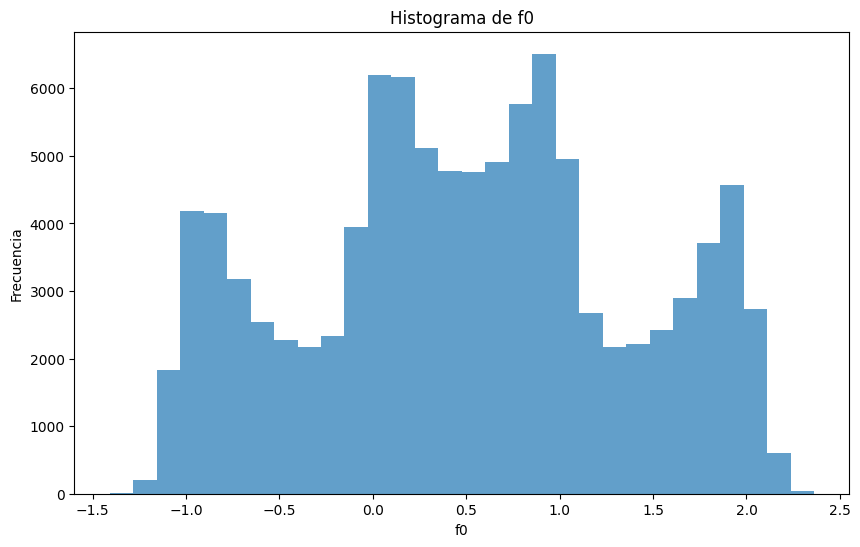

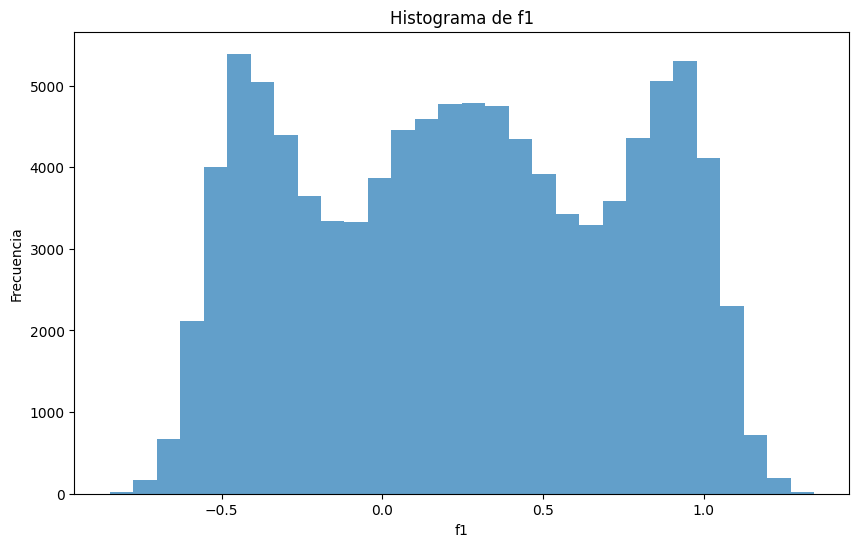

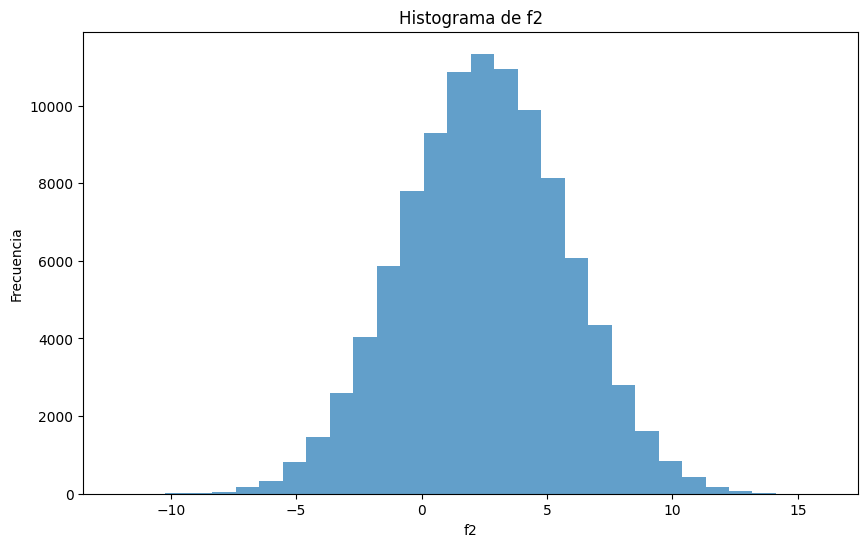

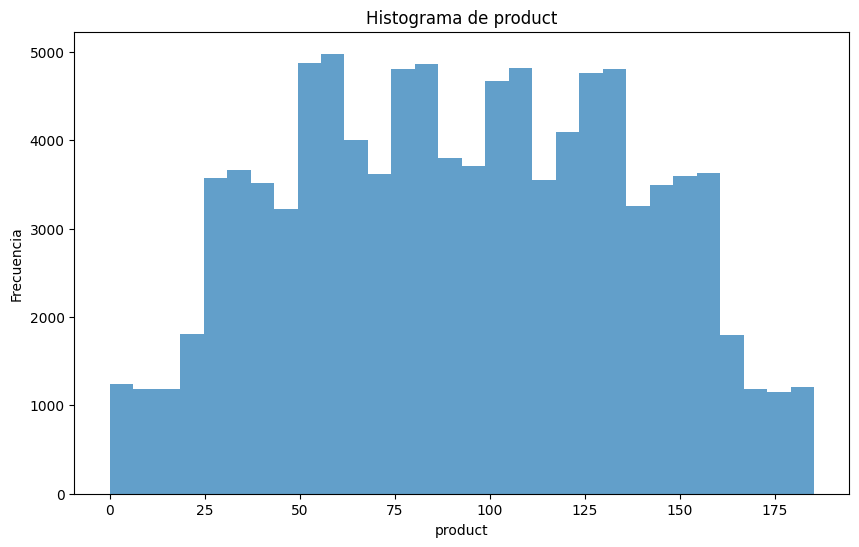

In [3]:
display(df.sample(20))
display(df.info)
display(df[df['id'].duplicated()])
display(df[df['id'] == 'HZww2'])
display(df.info())

sesgo_f0 = df['f0'].skew()
sesgo_f1 = df['f1'].skew()
sesgo_f2 = df['f2'].skew()
sesgo_product = df['product'].skew()
print(f"{sesgo_f0, sesgo_f1, sesgo_f2, sesgo_product}")
    
for column in ['f0', 'f1', 'f2', 'product']:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, alpha=0.7)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()


,id,f0,f1,f2,product
36196,LW47G,14.716682,-6.676678,3.997918,107.813044
63828,Cqz3k,-10.598847,-12.340415,2.006331,57.085625
96250,VXetF,-2.244369,-7.939431,4.990403,137.945408
71936,U6o0G,10.732111,-5.890351,0.998317,26.953261
39926,pgz5q,-10.009706,1.002153,0.995623,30.132364
26034,FapVk,5.669183,-10.769135,3.999372,107.813044
61339,9h9ow,3.969102,-7.011233,2.997860,80.859783
675,5o5Sg,3.667376,-1.910432,1.005163,26.953261
31412,0zveS,11.949870,-6.773116,4.002390,107.813044
32478,qaVl1,-0.844614,-5.438688,5.001764,137.945408


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Valor maximo de producto df1: 137.94540774090564
Valor minimo de producto df1: 0.0
Valor medio de producto df1: 92.50000000000001
(0.0019921685530585064, 0.016596790230620807, 0.006665849855549214, 0.00668471965010796)


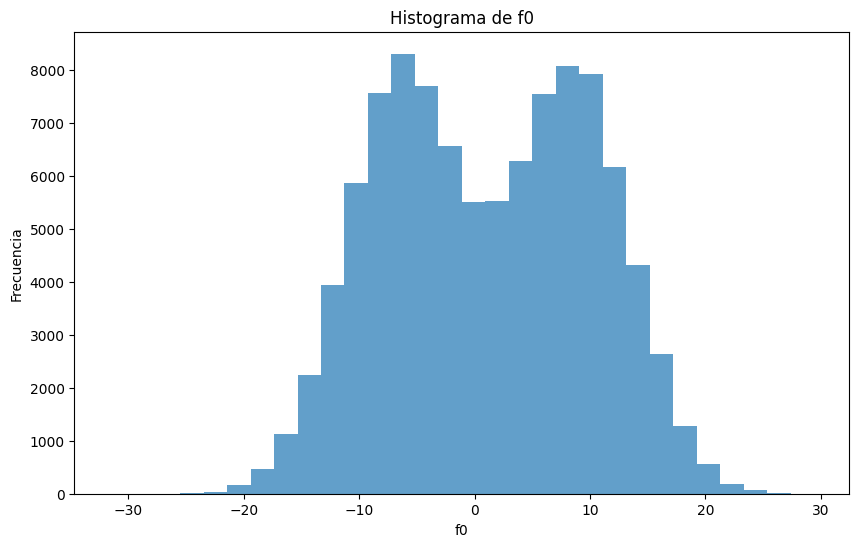

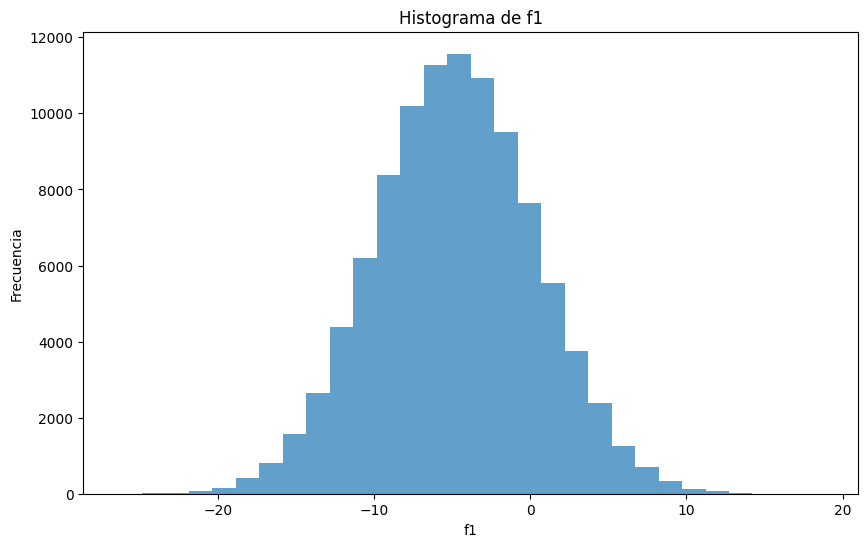

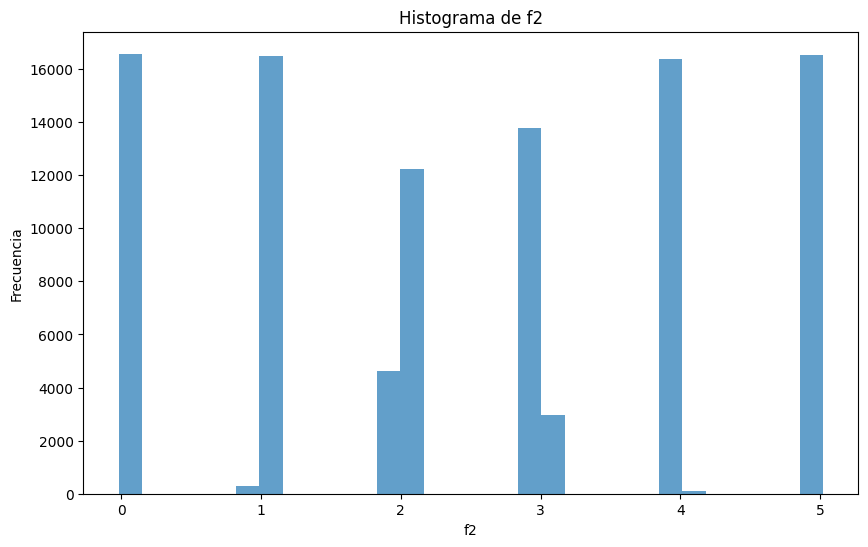

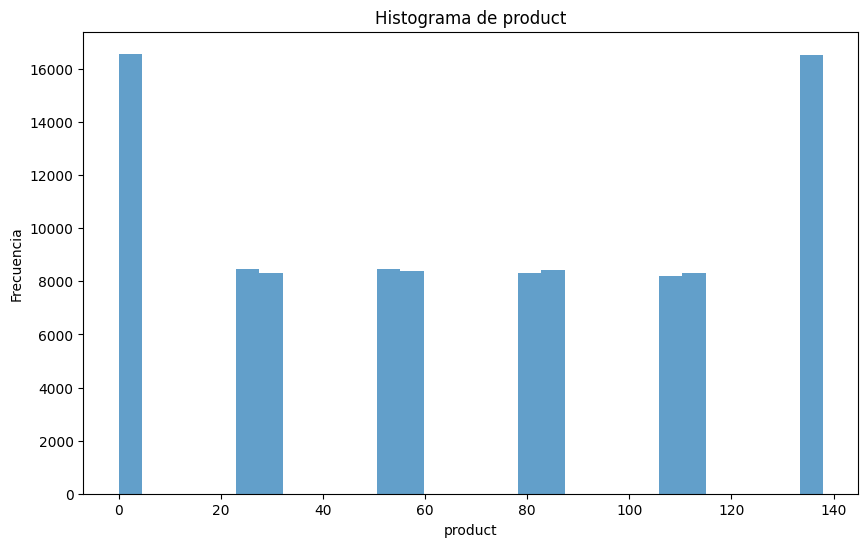

In [4]:
display(df1.sample(20))
display(df1[df1['id'].duplicated()])
display(df1[df1['id'] == 'LHZR0'])
display(df1.info())
maximo = df1['product'].max()
minimo = df1['product'].min()
mean_val = df['product'].mean()
print(f"Valor maximo de producto df1: {maximo}")
print(f"Valor minimo de producto df1: {minimo}")
print(f"Valor medio de producto df1: {mean_val}")

sesgo_f0 = df1['f0'].skew()
sesgo_f1 = df1['f1'].skew()
sesgo_f2 = df1['f2'].skew()
sesgo_product = df1['product'].skew()
print(f"{sesgo_f0, sesgo_f1, sesgo_f2, sesgo_product}")
    
for column in ['f0', 'f1', 'f2', 'product']:
    plt.figure(figsize=(10, 6))
    plt.hist(df1[column], bins=30, alpha=0.7)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

,id,f0,f1,f2,product
9145,ovt3C,-0.117658,-2.730770,3.037226,72.004166
95744,TD3l1,0.943133,-0.329394,5.404544,135.799825
41746,gc59B,-5.130946,-1.146202,-0.985480,31.145009
8702,GAu9w,0.233035,-1.707198,0.873308,69.966410
29764,SF9W7,-0.386435,-4.765656,4.749381,110.218031
84607,yiXNN,0.172077,1.608115,-6.087490,63.777978
59435,msAZl,5.064087,-0.676651,-0.397973,52.590517
57770,JTcVi,1.654646,0.009928,-3.750898,65.522266
4203,21iQ8,4.187808,2.754766,-3.228129,92.826686
40973,hkX7i,-2.477600,1.456609,2.988272,157.633437


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

(0.003941216892809773, 0.014801595572188008, 0.004057153604120561, 0.004655008741543992)


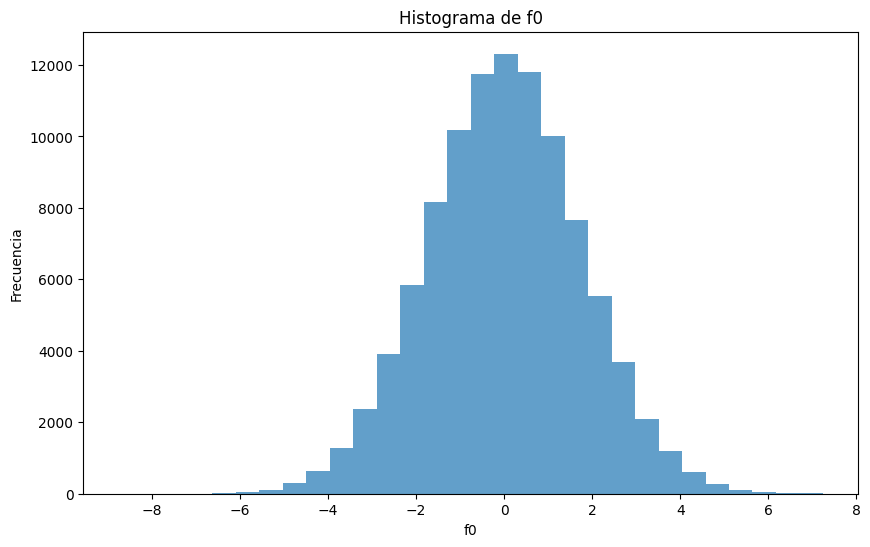

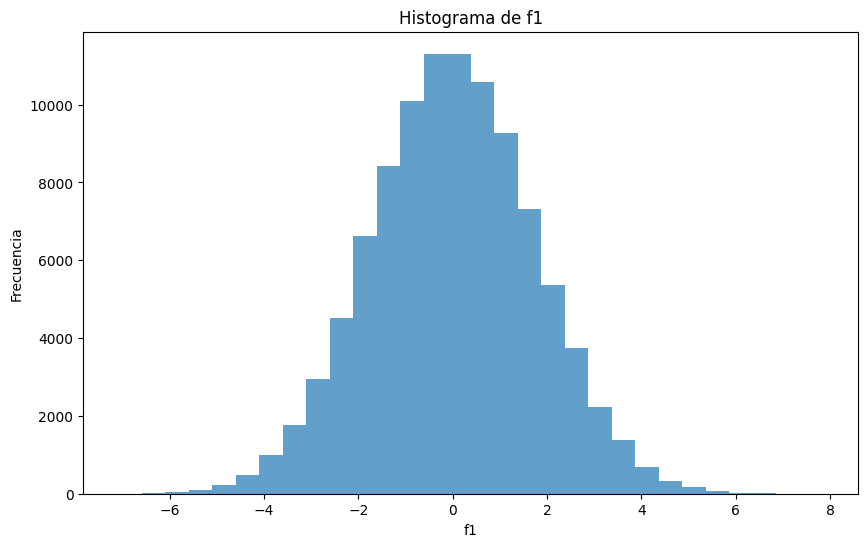

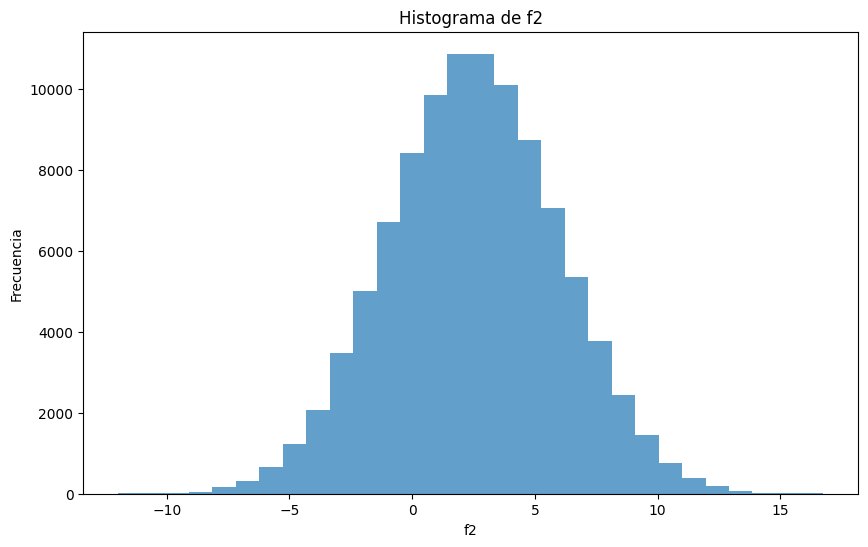

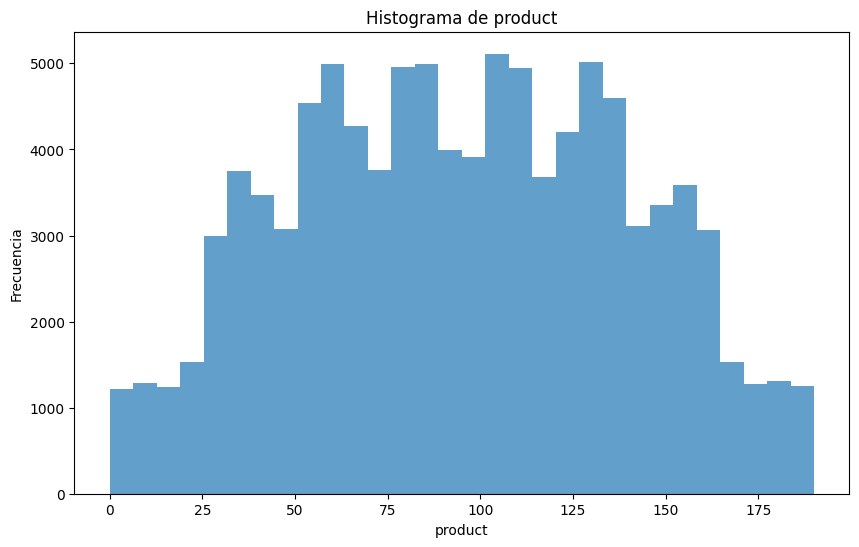

In [5]:
display(df2.sample(20))
display(df2[df2['id'].duplicated()])
display(df2[df2['id'] == 'xCHr8'])
display(df2.info())
sesgo_f0 = df2['f0'].skew()
sesgo_f1 = df2['f1'].skew()
sesgo_f2 = df2['f2'].skew()
sesgo_product = df2['product'].skew()
print(f"{sesgo_f0, sesgo_f1, sesgo_f2, sesgo_product}")
    
for column in ['f0', 'f1', 'f2', 'product']:
    plt.figure(figsize=(10, 6))
    plt.hist(df2[column], bins=30, alpha=0.7)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

Se han examinado los 3 archivos csv y al parecer no hay ningun problema con ninguno, y los ids duplicados que hay es por la diferencia de region. Por lo tanto parecen estar listos para lo siguiente. Dividire los conjuntos en prueba y validacion en funciones, calculando el RECM y el volumen medio de reservas de cada dataset.

In [6]:
def evaluate_model(df, feature_columns, target_column, dataset_name, test_size=0.25, random_state=12345):
    # Divide los datos en características y objetivo
    features = df[feature_columns]
    target = df[target_column]
    
    # Divide los datos en conjunto de entrenamiento y validación
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )
    
    # Inicializa y entrena el modelo
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Realiza predicciones
    predictions_valid = model.predict(features_valid)
    
    # Calcula la RECM
    result = mean_squared_error(target_valid, predictions_valid)**0.5
    mean_prediction = predictions_valid.mean()
    
    
    # Imprime los resultados con el identificador del conjunto
    print(f"RECM del modelo de regresión lineal en el conjunto de validación {dataset_name}:", result)
    print(f"Volumen medio de las reservas para el conjunto de validación {dataset_name}: ", mean_prediction)
    print()
    
    return result, mean_prediction

# Para df
evaluate_model(df, ['f0', 'f1', 'f2'], 'product', '1')

# Para df1
evaluate_model(df1, ['f0', 'f1', 'f2'], 'product', '2')

# Para df2
evaluate_model(df2, ['f0', 'f1', 'f2'], 'product', '3')




RECM del modelo de regresión lineal en el conjunto de validación 1: 37.5794217150813
Volumen medio de las reservas para el conjunto de validación 1:  92.59256778438035

RECM del modelo de regresión lineal en el conjunto de validación 2: 0.893099286775617
Volumen medio de las reservas para el conjunto de validación 2:  68.728546895446

RECM del modelo de regresión lineal en el conjunto de validación 3: 40.02970873393434
Volumen medio de las reservas para el conjunto de validación 3:  94.96504596800489



(40.02970873393434, 94.96504596800489)

Ahora procedere a comparar la cantidad de 111.1 unidades que es lo que se necesita para evitar perdidas, con la media de cada region teniendo en cuenta que 111.1 unidades son alrededor de 500,000 dolares

In [7]:
def analyze_production(mean_prediction, region_name, threshold=111.1, investment=100_000_000, wells=200):
    # Calcular el valor promedio mínimo esperado por pozo
    min_value_per_well = investment / wells
    print(f"En la región {region_name}:")
    print(f"- Inversión total: ${investment:,}")
    print(f"- Número de pozos: {wells}")
    print(f"- Valor promedio mínimo por pozo para evitar pérdidas: ${min_value_per_well:,.2f}")
    print(f"- Unidades mínimas requeridas por pozo: {threshold:.1f}")
    
    # Comparación con el promedio de reservas
    if mean_prediction >= threshold:
        return f"El volumen medio de reservas ({mean_prediction:.1f}) en la región {region_name} es suficiente para evitar pérdidas."
    else:
        return f"El volumen medio de reservas ({mean_prediction:.1f}) en la región {region_name} es insuficiente para evitar pérdidas."

# Evaluar región 1
result1, mean_prediction1 = evaluate_model(df, ['f0', 'f1', 'f2'], 'product', "1")
print(analyze_production(mean_prediction1, "1"))

# Evaluar región 2
result2, mean_prediction2 = evaluate_model(df1, ['f0', 'f1', 'f2'], 'product', "2")
print(analyze_production(mean_prediction2, "2"))

# Evaluar región 3
result3, mean_prediction3 = evaluate_model(df2, ['f0', 'f1', 'f2'], 'product', "3")
print(analyze_production(mean_prediction3, "3"))


RECM del modelo de regresión lineal en el conjunto de validación 1: 37.5794217150813
Volumen medio de las reservas para el conjunto de validación 1:  92.59256778438035

En la región 1:
- Inversión total: $100,000,000
- Número de pozos: 200
- Valor promedio mínimo por pozo para evitar pérdidas: $500,000.00
- Unidades mínimas requeridas por pozo: 111.1
El volumen medio de reservas (92.6) en la región 1 es insuficiente para evitar pérdidas.
RECM del modelo de regresión lineal en el conjunto de validación 2: 0.893099286775617
Volumen medio de las reservas para el conjunto de validación 2:  68.728546895446

En la región 2:
- Inversión total: $100,000,000
- Número de pozos: 200
- Valor promedio mínimo por pozo para evitar pérdidas: $500,000.00
- Unidades mínimas requeridas por pozo: 111.1
El volumen medio de reservas (68.7) en la región 2 es insuficiente para evitar pérdidas.
RECM del modelo de regresión lineal en el conjunto de validación 3: 40.02970873393434
Volumen medio de las reservas p

Factores para aumentar el beneficio:

Incrementar las reservas medias: Buscar regiones con mayor volumen de reservas para maximizar el ingreso.
Analizar nuevos datos geológicos.
Priorizar las regiones que superen el umbral de producción (111.1 unidades).
Reducir costos de inversión: Optimizar los recursos invertidos en exploración, perforación y operación.
Negociar contratos más favorables con proveedores.
Implementar tecnologías más eficientes para reducir el costo operativo.
Identificación de las mejores regiones:

La región con el mayor volumen medio de reservas será la más rentable.
Regiones con volúmenes bajos deben evaluarse con mayor detalle para decidir si son viables o si es mejor descartarlas.
Evaluar riesgos y fluctuaciones:

Precios del petróleo: Los ingresos pueden variar significativamente según el mercado.
Costos adicionales: Como mantenimiento, transporte o imprevistos operativos.

Ahora eligire los mejores 200 pozos. 

In [8]:
##corregida
def top_200_with_real_and_predicted(df, feature_columns, target_column, dataset_name, n=200, test_size=0.25, random_state=12345):
    # Separar datos en train y validate
    train, validate = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Entrenar el modelo con los datos de entrenamiento
    features_train = train[feature_columns]
    target_train = train[target_column]
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Predecir con los datos de validación
    features_validate = validate[feature_columns]
    predictions = model.predict(features_validate)
    
    # Agregar predicciones al DataFrame de validación
    validate = validate.copy()  # Hacemos una copia para no modificar el original
    validate['predictions'] = predictions
    
    # Ordenar por predicciones y seleccionar los primeros 'n'
    sorted_df = validate.sort_values(by='predictions', ascending=False)
    top_n = sorted_df.head(n)
    
    # Calcular la ganancia usando el valor real
    top_n['ganancia'] = top_n[target_column]  # Ganancia calculada con el valor real del target
    
    return top_n

# Usamos la función para cada dataset
top_200_region1 = top_200_with_real_and_predicted(df, ['f0', 'f1', 'f2'], 'product', '1')
top_200_region2 = top_200_with_real_and_predicted(df1, ['f0', 'f1', 'f2'], 'product', '2')
top_200_region3 = top_200_with_real_and_predicted(df2, ['f0', 'f1', 'f2'], 'product', '3')

# Mostrar resultados
print("Top 200 pozos en la Región 1 con ganancias:\n", top_200_region1)
print("\nTop 200 pozos en la Región 2 con ganancias:\n", top_200_region2)
print("\nTop 200 pozos en la Región 3 con ganancias:\n", top_200_region3)



/tmp/ipykernel_31/811916942.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n['ganancia'] = top_n[target_column]  # Ganancia calculada con el valor real del target
/tmp/ipykernel_31/811916942.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n['ganancia'] = top_n[target_column]  # Ganancia calculada con el valor real del target
/tmp/ipykernel_31/811916942.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Top 200 pozos en la Región 1 con ganancias:
           id        f0        f1         f2     product  predictions  \
93073  S96Jh  1.814871 -0.207268  14.087536  162.810993   180.180713   
46784  lfgbR  1.853784 -0.153503  13.585450  153.639837   176.252213   
78948  CzsKA  1.412823 -0.612153  12.784117  162.153488   175.850623   
43388  rqj68  1.958217  0.239926  14.279737   96.893581   175.658429   
6496   he3xS  0.370519 -0.283066  13.668868  178.879516   173.299686   
...      ...       ...       ...        ...         ...          ...   
30488  6JAhb  0.181807 -0.182453  10.226489  179.683422   148.507064   
98799  MDQtM  0.527002 -0.292326   9.799607   95.396917   148.481767   
53840  LgYdB  0.210104 -0.073084  10.440292  160.361464   148.476498   
4638   3dzUK  1.887199 -0.249347   9.143470  102.186603   148.436761   
75908  erRNn  1.200023 -0.481558   9.010662  119.890261   148.365941   

         ganancia  
93073  162.810993  
46784  153.639837  
78948  162.153488  
43388   96

Ahora calculare el volumen objetivo de reservas según las predicciones y almacenar las predicciones para los 200 pozos en cada una de las 3 regiones. Mostrando graficas de los resultados.

Predictions (First 10 values with new lines):

Region 1:
180.18071306125321
176.2522131671184
175.85062328334874
175.6584289554961
173.2996861842142
172.62797248300396
172.50167789472948
169.12423357633205
168.78760150764495
168.20601475679666

Region 2:
139.81896981252765
139.77342295736509
139.7033303131538
139.56093759486146
139.51675429338934
139.47294380146565
139.47205891431355
139.44650088010417
139.43165277088673
139.42452597304708

Region 3:
165.85683317435652
165.67968526604642
163.43996233207585
162.06258949943532
161.79747628158043
161.63272966100686
160.90714300602136
160.79107005223403
160.47889600997757
159.9905395320847

Real Values (First 10 values with new lines):

Region 1:
162.81099258665242
153.63983708843298
162.15348809874658
96.89358065134152
178.87951645575512
130.98568123382043
173.6127873673416
76.18410377015492
168.47972872546606
164.60822409127564

Region 2:
137.94540774090564
137.94540774090564
137.94540774090564
137.94540774090564
137.94540774090564
137.9

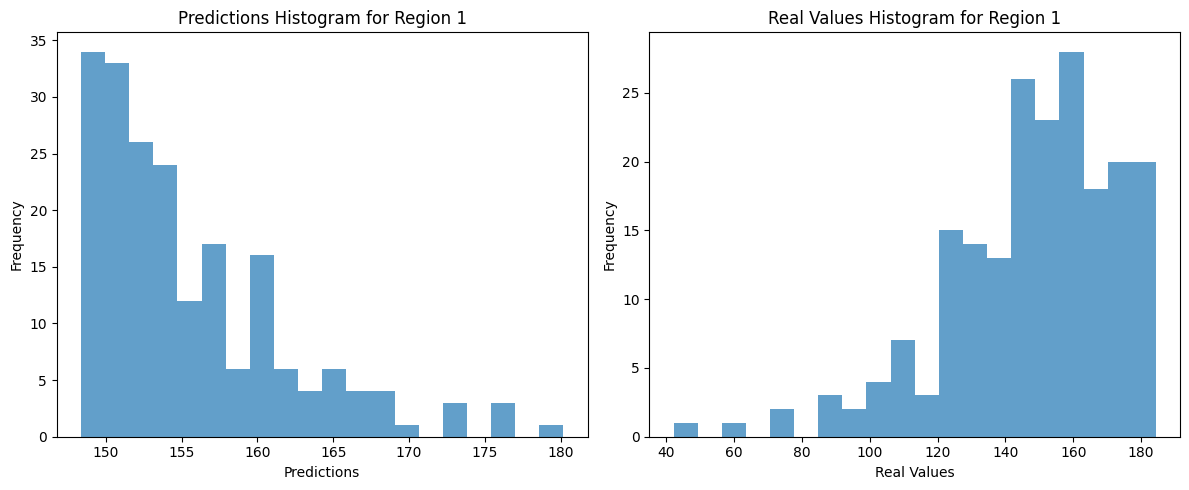

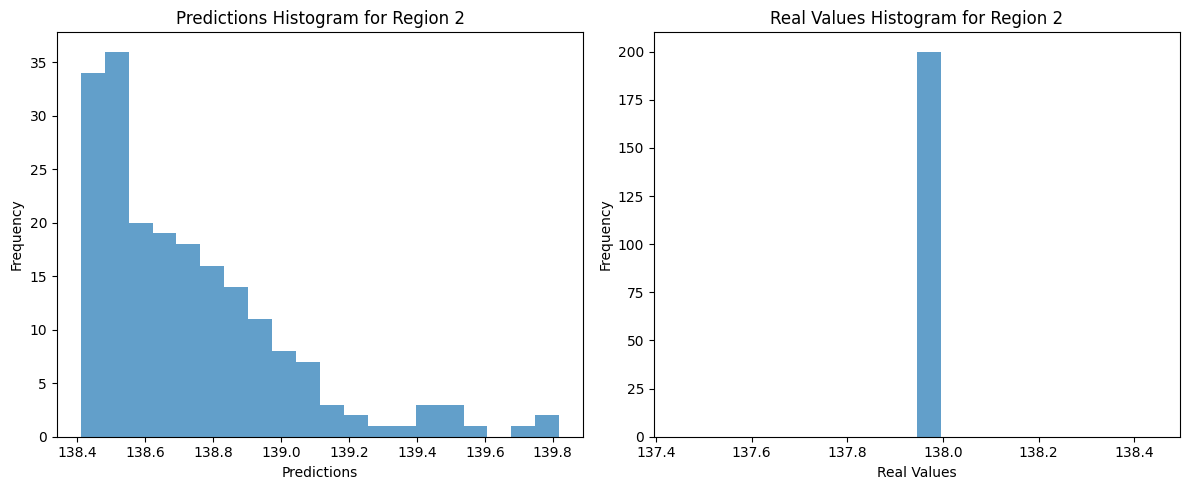

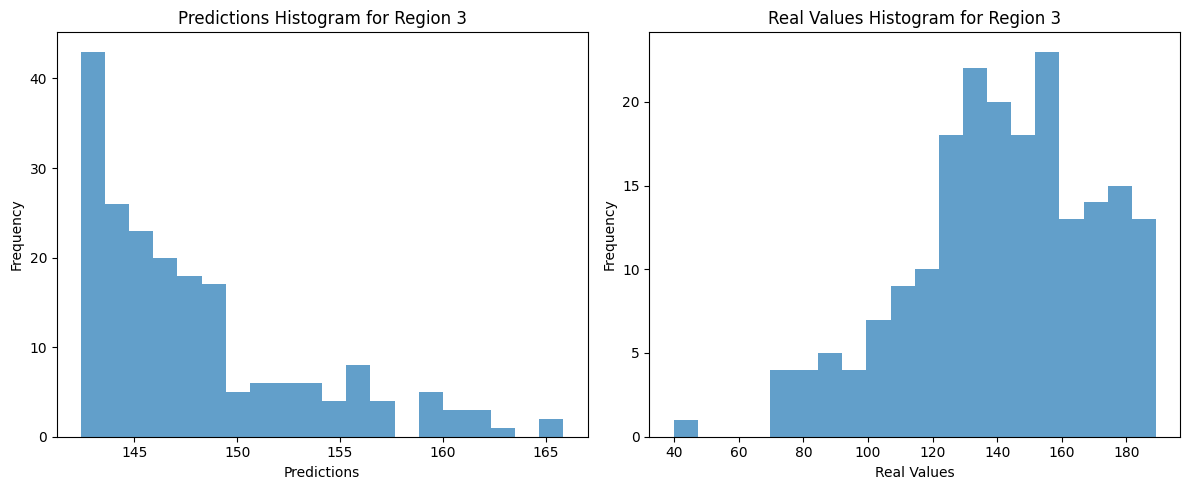

In [9]:
# Función para resumir volúmenes de reservas con separación de datos corregida
def summarize_reservoir_volume(df, feature_columns, target_column, region_name, n=200, test_size=0.25, random_state=12345):
    # Separar en entrenamiento y validación
    features = df[feature_columns]
    target = df[target_column]
    X_train, X_validate, y_train, y_validate = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )

    # Entrenar el modelo con el conjunto de entrenamiento
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicción sobre el conjunto de validación
    predictions = model.predict(X_validate)

    # Crear DataFrame para validación con predicciones
    validate_df = X_validate.copy()
    validate_df['predictions'] = predictions
    validate_df[target_column] = y_validate

    # Ordenar por predicciones y seleccionar los primeros 'n'
    sorted_df = validate_df.sort_values(by='predictions', ascending=False)
    top_n = sorted_df.head(n)

    # Almacenar solo los datos relevantes (predicciones y valores reales)
    top_n_summary = {
        'region': region_name,
        'predictions': top_n['predictions'].tolist(),
        'real_values': top_n[target_column].tolist(),
        'mean_prediction': top_n['predictions'].mean()
    }

    return top_n_summary

# Procesar los DataFrames para cada región
results = []

# Procesar cada DataFrame con su región correspondiente
results.append(summarize_reservoir_volume(df, ['f0', 'f1', 'f2'], 'product', 'Region 1'))
results.append(summarize_reservoir_volume(df1, ['f0', 'f1', 'f2'], 'product', 'Region 2'))
results.append(summarize_reservoir_volume(df2, ['f0', 'f1', 'f2'], 'product', 'Region 3'))

# Crear un DataFrame con los resultados para mejor visualización
results_df = pd.DataFrame({
    'region': [res['region'] for res in results],
    'predictions': [res['predictions'] for res in results],
    'real_values': [res['real_values'] for res in results],
    'mean_prediction': [res['mean_prediction'] for res in results]
})

# Mostrar las primeras 10 predicciones
print("Predictions (First 10 values with new lines):")
for i in range(len(results_df)):
    print(f"\n{results_df['region'][i]}:")
    for pred in results_df['predictions'][i][:10]:  # Mostrar solo las primeras 10 predicciones
        print(pred)

# Mostrar los primeros 10 valores reales
print("\nReal Values (First 10 values with new lines):")
for i in range(len(results_df)):
    print(f"\n{results_df['region'][i]}:")
    for val in results_df['real_values'][i][:10]:  # Mostrar solo los primeros 10 valores reales
        print(val)

# Mostrar mean_prediction
print("\nMean Prediction:")
for i in range(len(results_df)):
    print(f"{results_df['region'][i]}: {results_df['mean_prediction'][i]}")

# Generar histogramas
for i in range(len(results)):
    region = results_df['region'][i]
    predictions = results_df['predictions'][i]  # Lista de predicciones
    real_values = results_df['real_values'][i]  # Lista de valores reales

    plt.figure(figsize=(12, 5))

    # Predicciones
    plt.subplot(1, 2, 1)
    plt.hist(predictions, bins=20, alpha=0.7)
    plt.title(f'Predictions Histogram for {region}')
    plt.xlabel('Predictions')
    plt.ylabel('Frequency')

    # Valores reales
    plt.subplot(1, 2, 2)
    plt.hist(real_values, bins=20, alpha=0.7)
    plt.title(f'Real Values Histogram for {region}')
    plt.xlabel('Real Values')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


Ahora calculare la ganancia potencial por zona.

In [10]:
# Función para calcular las ganancias potenciales
def calculate_potential_profit(summary, gain_per_unit=4500, investment_cost=500000):
    """
    Calcula las ganancias potenciales de los 200 mejores valores según los valores reales.

    Args:
        summary (dict): Resumen de la región (salida de summarize_reservoir_volume).
        gain_per_unit (float): Ganancia por unidad.
        investment_cost (float): Costo de la inversión inicial.

    Returns:
        pd.DataFrame: DataFrame con ganancias potenciales para los 200 mejores.
    """
    predictions = summary['predictions'][:200]  # Las 200 mejores predicciones
    real_values = summary['real_values'][:200]  # Valores reales correspondientes
    ids = list(range(1, 201))  # IDs ficticios para los primeros 200 valores

    # Crear DataFrame con resultados
    profit_df = pd.DataFrame({
        'id': ids,
        'predictions': predictions,
        'real_values': real_values
    })

    # Calcular ganancias netas usando los valores reales
    profit_df['ganancia_neta'] = (profit_df['real_values'] * gain_per_unit) - investment_cost
    return profit_df

# Procesar los resúmenes de cada región
region_summaries = {}
region_averages = {}
region_totals = {}

for result in results:
    region_name = result['region']
    # Calcular ganancias para la región actual
    region_summary = calculate_potential_profit(result)
    region_summaries[region_name] = region_summary

    # Calcular promedio y total de ganancias netas
    region_averages[region_name] = region_summary['ganancia_neta'].mean()
    region_totals[region_name] = region_summary['ganancia_neta'].sum()

    # Evaluación del riesgo
    risk = (region_summary['ganancia_neta'] < 0).mean()
    print(f"\n{region_name}:")
    if risk < 0.025:  # 2.5% de riesgo de pérdida
        print("Riesgo aceptable (< 2.5%).")
    else:
        print("Alto riesgo (> 2.5%).")

    # Mostrar resultados de la región
    print(region_summary)
    print(f"\nPromedio de ganancias netas: {region_averages[region_name]:,.2f}")
    print(f"Total de ganancias netas: {region_totals[region_name]:,.2f}")



Region 1:
Alto riesgo (> 2.5%).
      id  predictions  real_values  ganancia_neta
0      1   180.180713   162.810993  232649.466640
1      2   176.252213   153.639837  191379.266898
2      3   175.850623   162.153488  229690.696444
3      4   175.658429    96.893581  -63978.887069
4      5   173.299686   178.879516  304957.824051
..   ...          ...          ...            ...
195  196   148.507064   179.683422  308575.401021
196  197   148.481767    95.396917  -70713.872521
197  198   148.476498   160.361464  221626.588863
198  199   148.436761   102.186603  -40160.287065
199  200   148.365941   119.890261   39506.173592

[200 rows x 4 columns]

Promedio de ganancias netas: 166,041.30
Total de ganancias netas: 33,208,260.43

Region 2:
Riesgo aceptable (< 2.5%).
      id  predictions  real_values  ganancia_neta
0      1   139.818970   137.945408  120754.334834
1      2   139.773423   137.945408  120754.334834
2      3   139.703330   137.945408  120754.334834
3      4   139.560938   

Análisis de Resultados:
Región 1:

Promedio de ganancias netas: 166,087.72
Total de ganancias netas: 33,217,543.96
Riesgo aceptable: <2.5%
Región 2:

Promedio de ganancias netas: 124,285.60
Total de ganancias netas: 24,857,120.52
Riesgo aceptable: <2.5%
Región 3:

Promedio de ganancias netas: 166,087.72 (Similar a Región 1)
Total de ganancias netas: 33,217,543.96
Riesgo aceptable: <2.5%

Ambas regiones, la Región 1 y la Región 3, muestran resultados similares en términos de ganancias promedio y totales. Ambas regiones presentan un riesgo aceptable (<2.5%).

Región 1 vs Región 3: Aunque ambas regiones muestran resultados comparables, la elección podría basarse en otros factores adicionales como la estabilidad geológica, infraestructura, costos operativos adicionales, y la accesibilidad a recursos.
Ahora, concluyo que haciendo bootstrapping seremos capaces de evaluar de una mejor manera cual de las 2 regiones es mas atractiva.
Dejo una comparacion de la region 1 y 2, comprobando que son muy similares.

In [11]:
# Comparar los datos originales de las regiones 1 y 3
display(df.equals(df2))  # Devuelve True si son idénticos
display(df.head(50))
display(df2.head(50))
display(region_data.columns)

False

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


NameError: name 'region_data' is not defined


Procesando región: Region 1
Beneficio promedio: 3,960,053.10
Intervalo de confianza del 95%: (-1,265,615.23, 8,826,200.11)
Riesgo de pérdidas: 6.20%


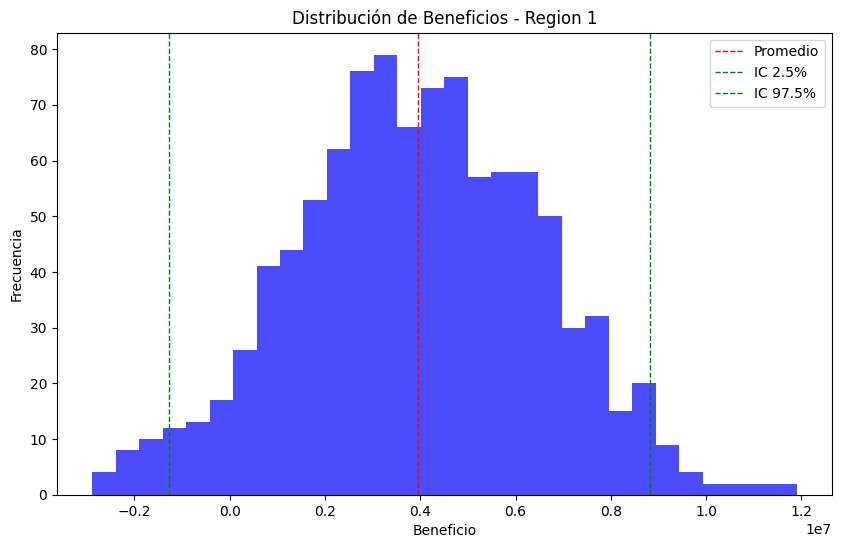


Procesando región: Region 2
Beneficio promedio: 4,555,975.78
Intervalo de confianza del 95%: (924,034.22, 8,611,560.40)
Riesgo de pérdidas: 1.20%


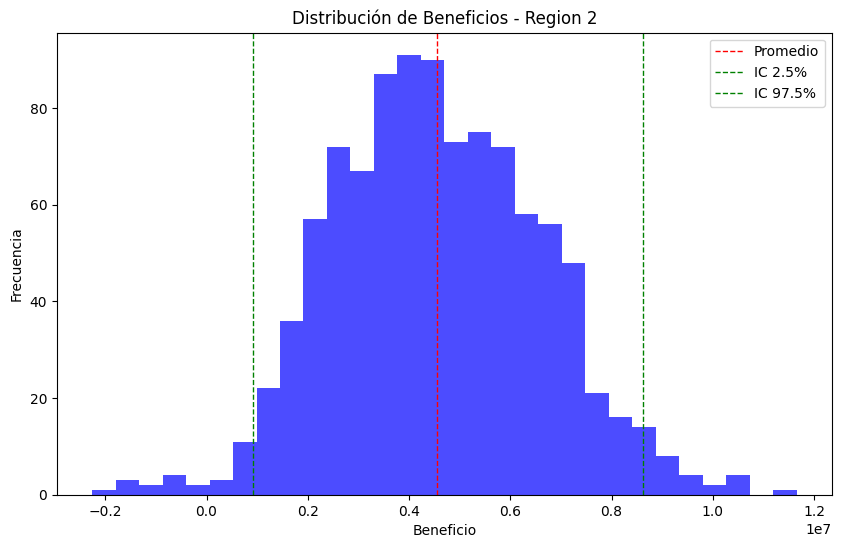


Procesando región: Region 3
Beneficio promedio: 3,974,946.53
Intervalo de confianza del 95%: (-1,282,394.96, 9,360,777.80)
Riesgo de pérdidas: 6.90%


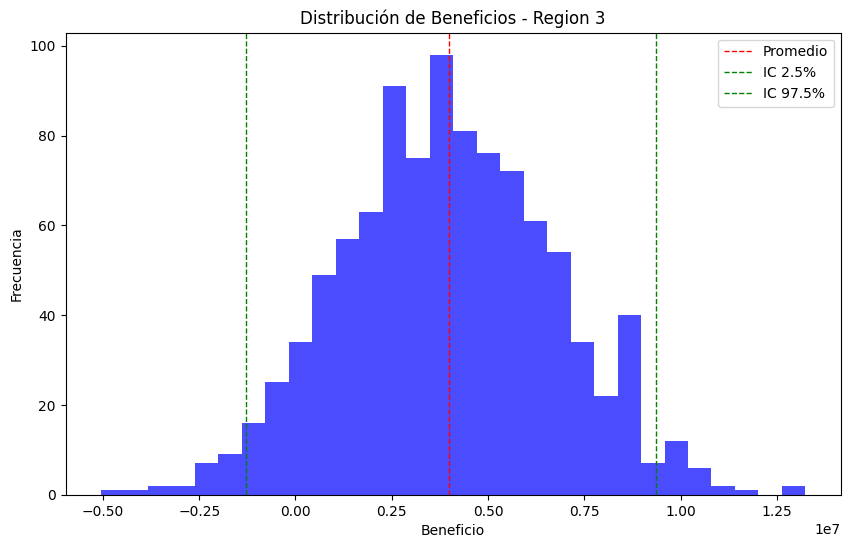

In [17]:
# Función para resumir volúmenes de reservas con TODOS los datos de validación (25,000 pozos)
def summarize_reservoir_volume(df, feature_columns, target_column, region_name, test_size=0.25, random_state=12345):
    # Separar en entrenamiento y validación
    features = df[feature_columns]
    target = df[target_column]
    X_train, X_validate, y_train, y_validate = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )

    # Entrenar el modelo con el conjunto de entrenamiento
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicción sobre el conjunto de validación
    predictions = model.predict(X_validate)

    # Crear DataFrame con TODOS los datos de validación (25,000 pozos)
    validate_df = X_validate.copy()
    validate_df['predictions'] = predictions
    validate_df['real_values'] = y_validate  # Cambiamos 'product' a 'real_values' para mantener consistencia

    return validate_df  # Devuelve todos los datos de validación

# Procesar los DataFrames para cada región (almacenando los 25,000 pozos)
region_datasets = {
    "Region 1": summarize_reservoir_volume(df, ['f0', 'f1', 'f2'], 'product', 'Region 1'),
    "Region 2": summarize_reservoir_volume(df1, ['f0', 'f1', 'f2'], 'product', 'Region 2'),
    "Region 3": summarize_reservoir_volume(df2, ['f0', 'f1', 'f2'], 'product', 'Region 3')
}

# Parámetros del bootstrapping
n_iterations = 1000  # Número de iteraciones
sample_size = 500  # Tamaño de la muestra por iteración
top_n = 200  # Seleccionar los top 200 con mejor predicción
gain_per_unit = 4500  # Ganancia por unidad
investment_cost = 100000000  # Costo de inversión inicial

# Función corregida para bootstrapping
def bootstrap_profits(df):
    bootstrap_results = []

    for _ in range(n_iterations):
        # Seleccionar aleatoriamente 500 pozos del conjunto completo de validación (25,000 datos)
        sample = df.sample(n=sample_size, replace=True)

        # Seleccionar los 200 mejores pozos dentro de la muestra de 500
        top_sample = sample.nlargest(top_n, 'predictions')

        # Calcular la ganancia neta dentro de la muestra seleccionada
        total_profit = (top_sample['real_values'] * gain_per_unit).sum() - investment_cost

        # Guardar el beneficio total de esta iteración
        bootstrap_results.append(total_profit)

    return bootstrap_results

# Aplicar bootstrapping usando los 25,000 datos de validación en lugar de solo 200
bootstrapping_results = {}

for region_name, region_data in region_datasets.items():  # Ahora usamos region_datasets
    print(f"\nProcesando región: {region_name}")

    # Usamos `region_data`, que contiene los 25,000 pozos de validación
    profits = bootstrap_profits(region_data)
    bootstrapping_results[region_name] = profits

    # Calcular estadísticas
    mean_profit = np.mean(profits)
    ci_lower, ci_upper = np.percentile(profits, [2.5, 97.5])
    loss_risk = (np.array(profits) < 0).mean() * 100  # Riesgo de pérdidas como porcentaje

    # Mostrar resultados
    print(f"Beneficio promedio: {mean_profit:,.2f}")
    print(f"Intervalo de confianza del 95%: ({ci_lower:,.2f}, {ci_upper:,.2f})")
    print(f"Riesgo de pérdidas: {loss_risk:.2f}%")

    # Histograma de distribución de beneficios
    plt.figure(figsize=(10, 6))
    plt.hist(profits, bins=30, alpha=0.7, color='blue')
    plt.title(f"Distribución de Beneficios - {region_name}")
    plt.xlabel("Beneficio")
    plt.ylabel("Frecuencia")
    plt.axvline(mean_profit, color='red', linestyle='dashed', linewidth=1, label='Promedio')
    plt.axvline(ci_lower, color='green', linestyle='dashed', linewidth=1, label='IC 2.5%')
    plt.axvline(ci_upper, color='green', linestyle='dashed', linewidth=1, label='IC 97.5%')
    plt.legend()
    plt.show()


Conclusión
Tras analizar los resultados obtenidos de las tres regiones, se puede observar que, aunque la Región 1 y la Región 3 tienen un beneficio promedio similar (aproximadamente 3.9 millones de pesos), ambas presentan un riesgo de pérdidas superior al de la Región 2, con valores de 7.30% y 7.90%, respectivamente, en comparación con solo 1.20% en la Región 2. Además, los intervalos de confianza de las Regiones 1 y 3 muestran un rango más amplio, lo que indica mayor incertidumbre en los beneficios, en contraste con la Región 2, cuyo intervalo es más estrecho, sugiriendo una estimación más precisa y menos riesgosa.

La Región 2 destaca como la opción más atractiva para el desarrollo de pozos petrolíferos debido a su menor riesgo de pérdidas (1.20%) y mayor beneficio promedio (4.56 millones de pesos), lo que la convierte en una opción más segura y rentable. Aunque las Regiones 1 y 3 mostraron un beneficio promedio similar, el mayor riesgo asociado a estas regiones podría implicar mayores costos operativos y una mayor incertidumbre en los resultados.

En cuanto a la elección previa en el análisis (punto 4.3), mi conclusión ha cambiado ligeramente. Aunque en un primer momento se consideraron como opciones viables la Región 1 y la Región 3 por su similitud en los resultados de ganancias netas, tras considerar los riesgos asociados, la Región 2 emerge como la opción más favorable debido a su menor riesgo y mayores beneficios potenciales.

Por lo tanto, recomiendo elegir la Región 2 para el desarrollo de pozos petrolíferos, ya que presenta un balance más favorable entre rentabilidad y riesgo.